In [1]:
import os
import math
import sys
import glob
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from river import ensemble, tree
from river.preprocessing import StandardScaler,OneHotEncoder
from tqdm.notebook import tqdm

In [4]:
kind = 'all-cols-without-time'

In [5]:
variant = 'sine 750 mv'
pred_dir = os.path.join('predictions',variant)
metrics_dir = 'metrics'
rst_graph = os.path.join('graphs','outputs',variant)
metrics_graph = os.path.join('graphs','metrics',variant)

In [6]:
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
if not os.path.exists(metrics_dir):
    os.makedirs(metrics_dir)
if not os.path.exists(metrics_graph):
    os.makedirs(metrics_graph)
if not os.path.exists(rst_graph):
    os.makedirs(rst_graph)

In [7]:
metric_file ='rf_inc_{}-{}.csv'.format(variant, kind)

In [8]:
train_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\train".format(variant)
test_loc = "D:\\Final Year Project\\Play with DWT\\Sine\\dataset\\{}\\test".format(variant)

In [9]:
inputs = ['vdd','pd','xpd','vinp','vinn','temperature','process']

train_files = glob.glob(os.path.join(train_loc, "*.csv"))
test_files = glob.glob(os.path.join(test_loc, "*.csv"))

columns = ['vdd', 'pd','xpd', 'vinp', 'vinn', 'temperature', 'process']

dfs = list()
for fpath in train_files:
    df = pd.read_csv(fpath, usecols = columns)
    dfs.append(df)
df_train = pd.concat(dfs, ignore_index=True)

In [10]:
df_train.describe(),df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100000 entries, 0 to 2099999
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   vdd          float64
 1   pd           float64
 2   xpd          float64
 3   vinp         float64
 4   vinn         float64
 5   temperature  int64  
 6   process      object 
dtypes: float64(5), int64(1), object(1)
memory usage: 112.2+ MB


(                vdd            pd           xpd          vinp          vinn  \
 count  2.100000e+06  2.100000e+06  2.100000e+06  2.100000e+06  2.100000e+06   
 mean   3.179533e+00  7.673904e-01  2.412143e+00  1.204445e+00  1.123374e+00   
 std    5.357162e-01  1.343291e+00  1.461616e+00  7.557100e-01  6.789563e-01   
 min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 25%    3.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  3.757506e-01   
 50%    3.300000e+00  0.000000e+00  3.000000e+00  1.563639e+00  1.373618e+00   
 75%    3.600000e+00  9.540000e-01  3.300000e+00  1.687619e+00  1.650508e+00   
 max    3.600000e+00  3.600000e+00  3.600000e+00  2.025000e+00  2.020974e+00   
 
         temperature  
 count  2.100000e+06  
 mean   3.428571e+01  
 std    5.939750e+01  
 min   -5.500000e+01  
 25%   -1.500000e+01  
 50%    2.500000e+01  
 75%    8.500000e+01  
 max    1.250000e+02  ,
 None)

In [11]:
X = df_train.drop("vinn", axis = 1)
Y = pd.Series(df_train.vinn)

In [12]:
numeric_columns=list(X.select_dtypes(['float64','int64']).columns)
categorical_columns=list(X.select_dtypes('object').columns)
numeric_columns,categorical_columns

(['vdd', 'pd', 'xpd', 'vinp', 'temperature'], ['process'])

In [13]:
df_num = X[numeric_columns]
df_cat = X[categorical_columns]

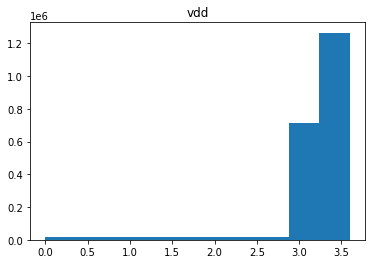

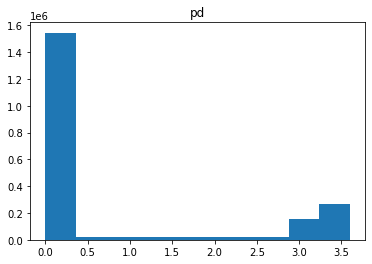

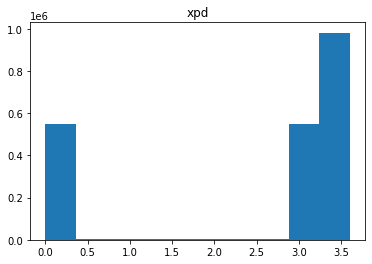

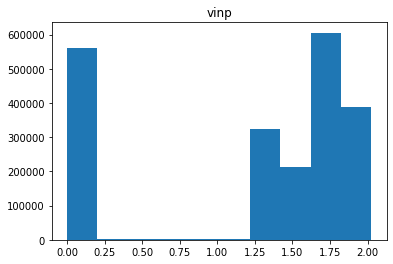

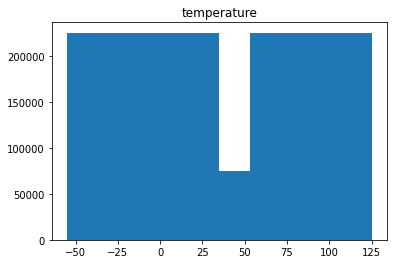

In [14]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

                  vdd        pd       xpd          vinp   temperature
vdd          1.000000 -0.031195  0.395193  3.265214e-01 -3.487269e-03
pd          -0.031195  1.000000 -0.930479 -2.164755e-01 -3.356627e-04
xpd          0.395193 -0.930479  1.000000  3.186285e-01 -9.696762e-04
vinp         0.326521 -0.216475  0.318629  1.000000e+00 -1.292792e-15
temperature -0.003487 -0.000336 -0.000970 -1.292792e-15  1.000000e+00


<AxesSubplot:>

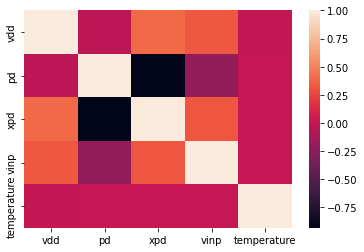

In [15]:
print(df_num.corr())
sns.heatmap(df_num.corr())

In [16]:
encoder = OneHotEncoder()

num_col= X[numeric_columns]
cat_col = X[categorical_columns]

cat = encoder.learn_many(cat_col).transform_many(cat_col)

X_train = pd.concat([num_col,cat],axis=1)

In [17]:
X_train.describe()

,vdd,pd,xpd,vinp,temperature,process_slownfastp,process_fastnslowp,process_slownslowp,process_typical,process_fastnfastp
count,2.100000e+06,2.100000e+06,2.100000e+06,2.100000e+06,2.100000e+06,2100000.0,2100000.0,2100000.0,2100000.0,2100000.0
mean,3.179533e+00,7.673904e-01,2.412143e+00,1.204445e+00,3.428571e+01,0.2,0.2,0.2,0.2,0.2
std,5.357162e-01,1.343291e+00,1.461616e+00,7.557100e-01,5.939750e+01,0.4,0.4,0.4,0.4,0.4
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.500000e+01,0.0,0.0,0.0,0.0,0.0
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.500000e+01,0.0,0.0,0.0,0.0,0.0
50%,3.300000e+00,0.000000e+00,3.000000e+00,1.563639e+00,2.500000e+01,0.0,0.0,0.0,0.0,0.0
75%,3.600000e+00,9.540000e-01,3.300000e+00,1.687619e+00,8.500000e+01,0.0,0.0,0.0,0.0,0.0
max,3.600000e+00,3.600000e+00,3.600000e+00,2.025000e+00,1.250000e+02,1.0,1.0,1.0,1.0,1.0


In [18]:
X_train = X_train.to_dict(orient='records')
X_train[:1]

[{'vdd': 0.0,
  'pd': 0.0,
  'xpd': 0.0,
  'vinp': 0.0,
  'temperature': -15,
  'process_slownfastp': 0,
  'process_fastnslowp': 0,
  'process_slownslowp': 0,
  'process_typical': 0,
  'process_fastnfastp': 1}]

In [19]:
def SNR(y,y_pred):
    n = len(y)
    upper=0
    lower=0
    for ind in range(0,n):
        out=y[ind]
        pred_out=y_pred[ind]
        upper=upper+(out*out)
        lower=lower+(out-pred_out)*(out-pred_out)
    snr=10*math.log10(upper/lower)
    return snr

In [20]:
base_model = tree.HoeffdingTreeRegressor(grace_period=50)
bag = ensemble.BaggingRegressor(model=base_model,n_models=10,seed=42)

In [21]:
st = time.time()
for i,x in tqdm(enumerate(X_train)): 
    bag.learn_one(x, Y[i])

elapsed = (time.time() - st)/60
print(f" Total time : {elapsed : .2f} minutes")

0it [00:00, ?it/s]

 Total time :  13.77 minutes


In [22]:
model_name = "RF_BAG_ALLCOLS_{}_{}_model.pkl".format(variant, kind)

pickle.dump(bag, open(model_name,'wb'))
print(model_name)

print("model saved")

RF_BAG_ALLCOLS_sine 750 mv_all-cols-without-time_model.pkl
model saved


In [29]:
test_files = glob.glob(test_loc + '/*.csv')

In [30]:
def predict(file,enc,m1):
    df_test = pd.read_csv(file, usecols = columns + ['time'])
    
    y_test = df_test['vinn']
    time = df_test['time']
    
    X = df_test.drop(["vinn","time"],axis=1)
    
    numeric_columns=list(X.select_dtypes(['float64','int64']).columns)
    categorical_columns=list(X.select_dtypes('object').columns)

    num_col= X[numeric_columns]
    cat_col = X[categorical_columns]
    
    cat_col = enc.transform_many(cat_col)
    
    x_test = pd.concat([num_col,cat_col],axis=1)
    
    x_test = x_test.to_dict(orient='records')
    
    y_pred_srp = [bag.predict_one(x) for i,x in tqdm(enumerate(x_test)) ]
    # y_pred_adf = [adf.predict_one(x) for i,x in tqdm(enumerate(x_test)) ]
    # y_pred_oxt = [oxt.predict_one(x) for i,x in tqdm(enumerate(x_test)) ]
    
    p1 = pd.Series(y_pred_srp)
    # p2 = pd.Series(y_pred_adf)
    # p3 = pd.Series(y_pred_oxt)
    
    mae1 = mean_absolute_error(y_test, p1)
    # mae2 = mean_absolute_error(y_test, p2)
    # mae3 = mean_absolute_error(y_test, p3)

    mse1 = mean_squared_error(y_test, p1)
    # mse2 = mean_squared_error(y_test, p2)
    # mse3 = mean_squared_error(y_test, p3)

    r2_1 = r2_score(y_test, p1)
    # r2_2 = r2_score(y_test, p2)
    # r2_3 = r2_score(y_test, p3)

    snr1 = SNR(y_test,p1)
    # snr2 = SNR(y_test,p2)
    # snr3 = SNR(y_test,p3)

    rmse1 = math.sqrt(mse1)
    # rmse2 = math.sqrt(mse2)
    # rmse3 = math.sqrt(mse3)
    
    df_result_srp = pd.DataFrame()
    # df_result_adf = pd.DataFrame()
    # df_result_oxt = pd.DataFrame()

    df_result_srp["Time"] = time
    # df_result_adf["Time"] = time
    # df_result_oxt["Time"] = time

    df_result_srp["actual vinn"] = y_test
    # df_result_adf["actual vinn"] = y_test
    # df_result_oxt["actual vinn"] = y_test

    df_result_srp["predicted vinn"] = p1
    # df_result_adf["predicted vinn"] = p2
    # df_result_oxt["predicted vinn"] = p3
    
    file_name = os.path.basename(file)

#     df_result_srp.to_csv(('./Incremental/RandomForest/Hoeffeding_trees/predictions_bg-seed/' +  file_name),index = False )
    df_result_srp.to_csv(pred_dir + '//' + file_name, index = False )
    # df_result.to_csv(('./predictions_adf/' +  file_name),index = False )
    # df_result_oxt.to_csv(('./predictions_oxt/' +  file_name),index = False )
    

    metrics_1 = {'file_name' : file_name, 'RMSE':round(rmse1,4), 'MSE': round(mse1,4), 'MAE':round(mae1,4), 'R2':round(r2_1,4), 'SNR':round(snr1,4)}
    # metrics_2 = {'file_name' : file_name,'RMSE':round(rmse2,4), 'MSE': round(mse2,4), 'MAE':round(mae2,4), 'R2':round(r2_2,4), 'SNR':round(snr2,4)}
    # metrics_3 = {'file_name' : file_name,'RMSE':round(rmse3,4), 'MSE': round(mse3,4), 'MAE':round(mae3,4), 'R2':round(r2_3,4), 'SNR':round(snr3,4)}
    
    m1 = m1.append(metrics_1, ignore_index = True)
    # m2 = m2.append(metrics_2, ignore_index = True)
    # m3 = m3.append(metrics_3, ignore_index = True)
    
    return m1

In [31]:
i = 1

metrics_df = pd.DataFrame()

for file in test_files:
    print("File : ",i)
    metrics_df = predict(file,encoder,metrics_df)
    print('-----------')
    i = i+1
# metrics_df.to_csv('srp regressor.csv', index = False )
# metrics['SNR'].avg()



File :  1


0it [00:00, ?it/s]

-----------
File :  2


0it [00:00, ?it/s]

-----------
File :  3


0it [00:00, ?it/s]

-----------
File :  4


0it [00:00, ?it/s]

-----------
File :  5


0it [00:00, ?it/s]

-----------
File :  6


0it [00:00, ?it/s]

-----------
File :  7


0it [00:00, ?it/s]

-----------
File :  8


0it [00:00, ?it/s]

-----------
File :  9


0it [00:00, ?it/s]

-----------
File :  10


0it [00:00, ?it/s]

-----------


In [32]:
metrics_df.to_csv(os.path.join(metrics_dir, metric_file), index = False)
metrics_df

,file_name,RMSE,MSE,MAE,R2,SNR
0,fastnfastp_3.3V_45.csv,0.1319,0.0174,0.0735,0.9617,20.2363
1,fastnfastp_3.6V_45.csv,0.1431,0.0205,0.0759,0.9541,19.5502
2,fastnslowp_3.3V_45.csv,0.2632,0.0693,0.1198,0.8542,13.9849
3,fastnslowp_3.6V_45.csv,0.2195,0.0482,0.1011,0.8982,15.6822
4,slownfastp_3.3V_45.csv,0.0994,0.0099,0.0577,0.9785,22.3629
5,slownfastp_3.6V_45.csv,0.1161,0.0135,0.0666,0.9708,21.0225
6,slownslowp_3.3V_45.csv,0.2270,0.0515,0.1055,0.8870,15.0584
7,slownslowp_3.6V_45.csv,0.1880,0.0353,0.0866,0.9230,16.7678
8,typical_3.3V_45.csv,0.1526,0.0233,0.0686,0.9491,18.6962
9,typical_3.6V_45.csv,0.1272,0.0162,0.0587,0.9643,20.3172


In [33]:
# Before executing this cell zip graphs_bag and download
def draw (file,name):
    df_fun=pd.read_csv(file)
    
    X_time=df_fun['Time']
    vinn = df_fun['actual vinn']
    pred_vinn = df_fun['predicted vinn']
    
    fig=plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
    plt.plot(X_time,vinn, color="red", linewidth=3, label = vinn)
    plt.plot(X_time,pred_vinn, color="blue", linewidth=3, label = pred_vinn)
    
    temp_values = {
        '-55':'-55T',
        '-35':'-35T',
        '-15':'-15T',
        '5':'5T',
        '25':'25T',
        '45':'45T',
        '65':'65T',
        '85':'85T',
        '105':'105T',
        '125':'125T',
    }
    
#     tokens = name.split('_')
#     temp = temp_values[tokens[-1][:-4]]
#     title =  "_".join(tokens[:-1] + [temp])
    title = name
    
    plt.xlabel("Time(ns)", fontsize=15)
    plt.ylabel("vinn", fontsize=15)
    plt.grid(True)
    plt.legend()
    plt.legend(["Actual vinn", "Predicted vinn"], loc ="lower right")
    plt.title(title)
    

    nm = rst_graph + '//' + title + ".jpg"
    plt.savefig(nm)

File  1
---------------
File  2
---------------
File  3
---------------
File  4
---------------
File  5
---------------
File  6
---------------
File  7
---------------
File  8
---------------
File  9
---------------
File  10
---------------


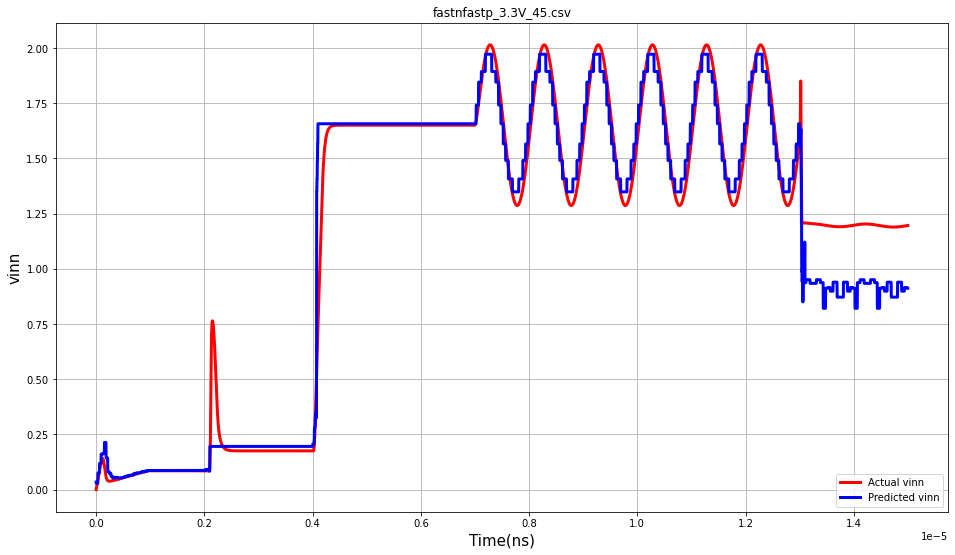

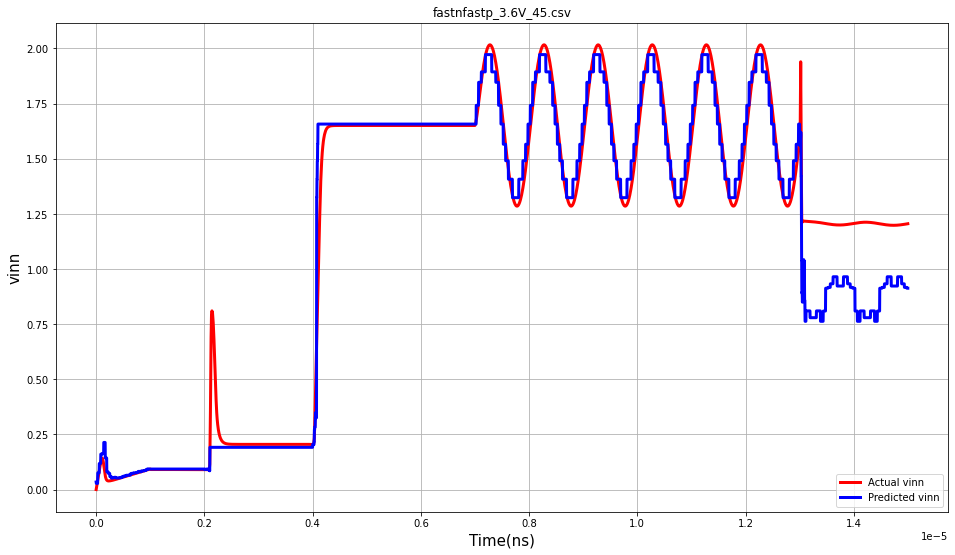

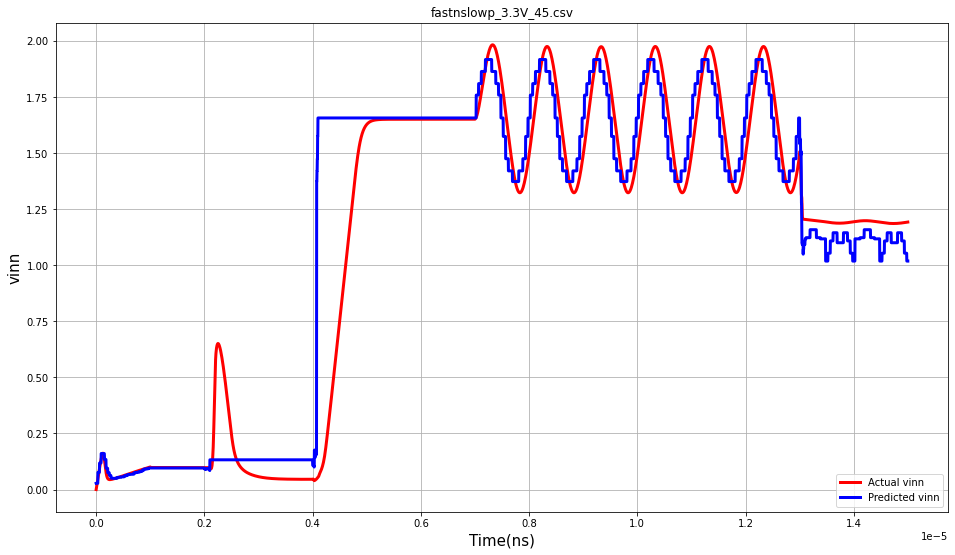

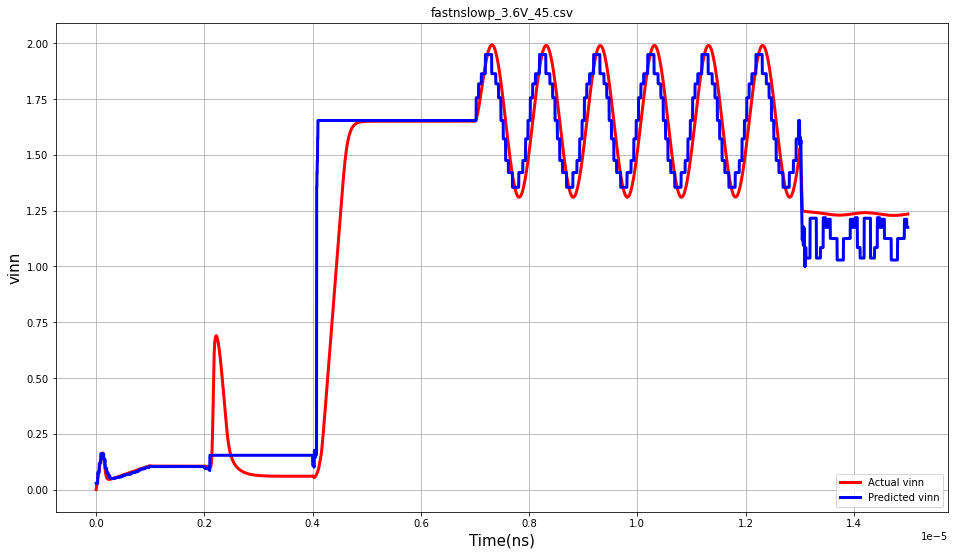

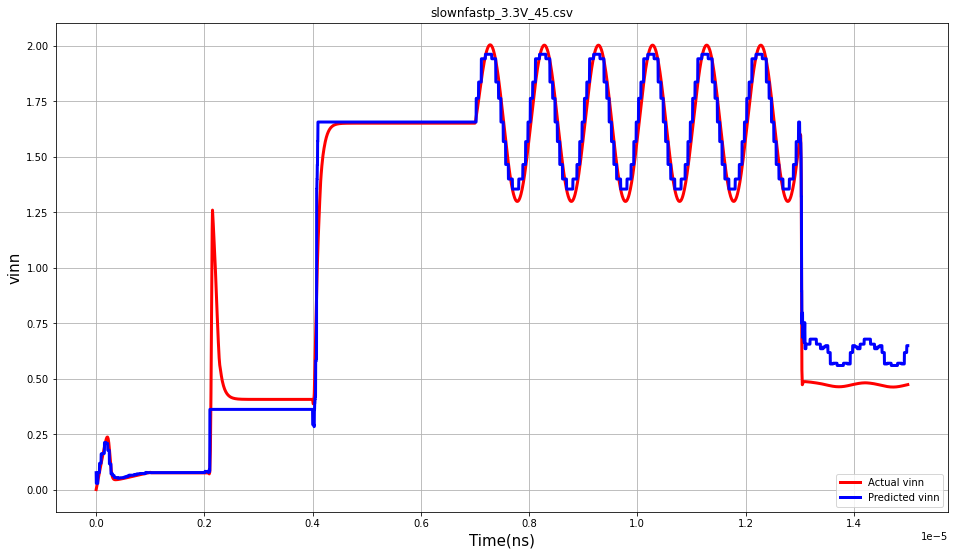

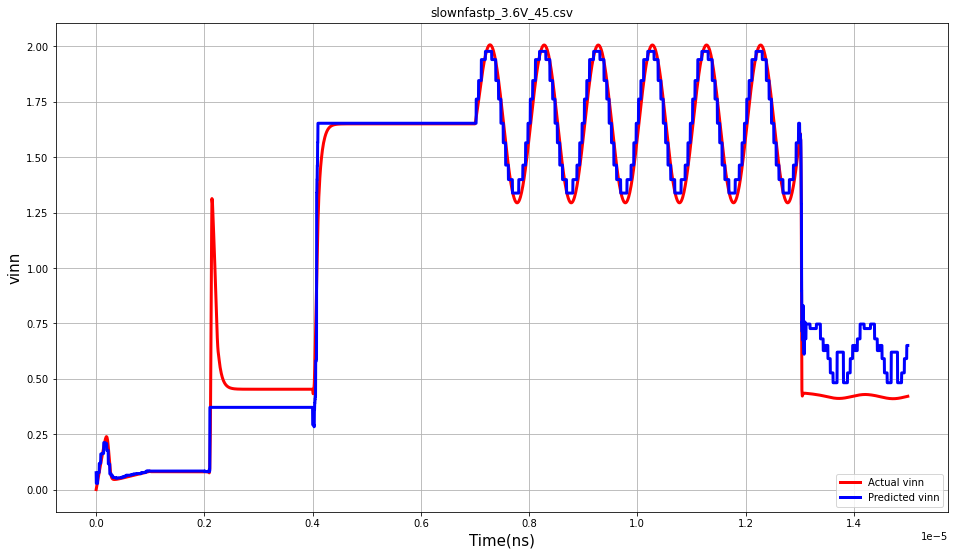

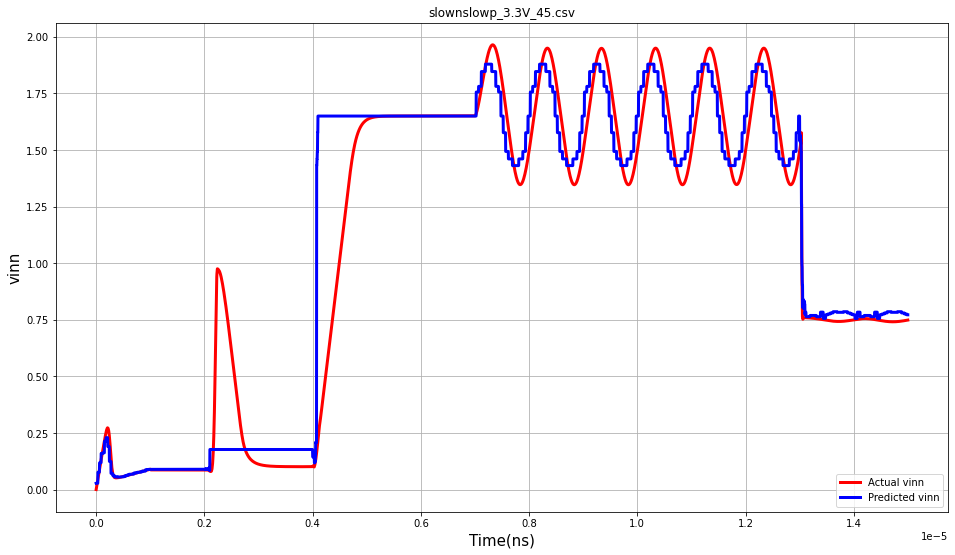

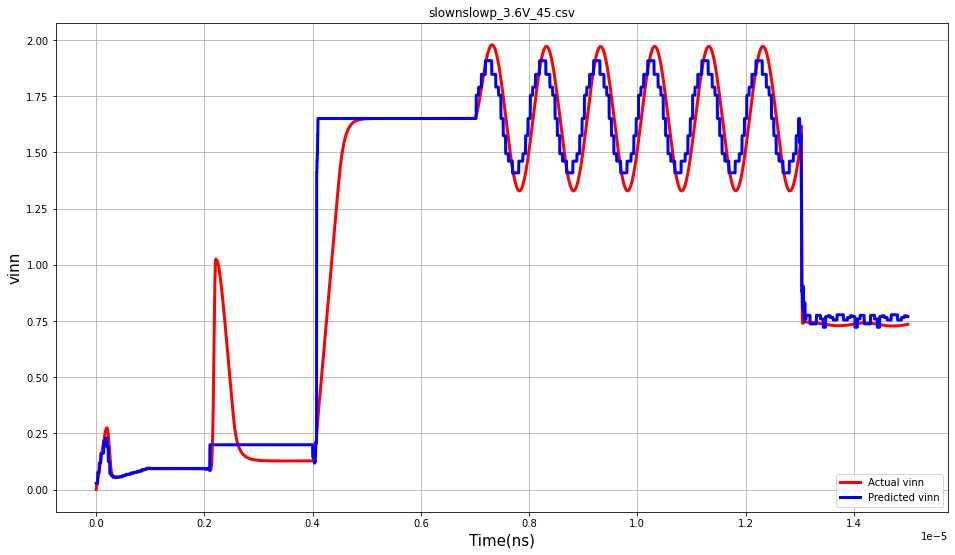

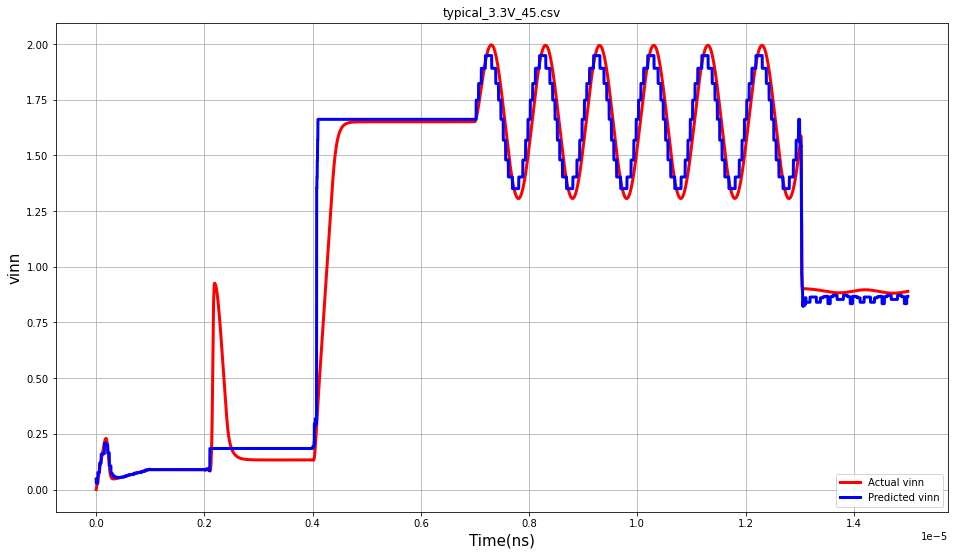

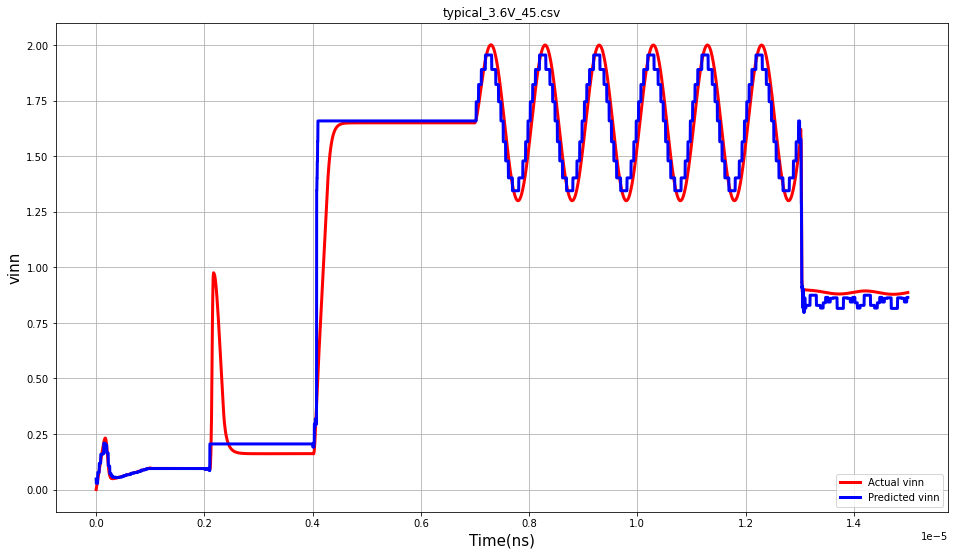

In [35]:
path = pred_dir + '//' + "*.csv"
count =0
for file in glob.glob(path):
    count = count+1
    print ("File ", count)
    print ("---------------")
    name = os.path.basename(file)
    draw(file,name)